# Polarity Classifier

In this notebook I find the adjectives within the text and classify them as either polar or neutral.

Firstly, initialise the Snorkel Session

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

Then, define the candidate subclass. The ['adjective'] means that the candidate consists of one span named adjective. As snorkel can be used for relation extraction, the examples in snorkel make a list of 2 elements (e.g. ['person1', 'person2']).  
NOTE: Making it just one element meant that  a change in LSTM training needed to be introduced  
TODO: link to the change

In [2]:
from snorkel.models import candidate_subclass

Sentiment = candidate_subclass('Sentiment', ['adjective'])

Read the reviews file by file from given directory. All files are at this parsed by spacy, so any previous pre-processing is not neccessary.

In [3]:
from snorkel.parser import TextDocPreprocessor

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

from snorkel.models import Document, Sentence

n_docs = 500
doc_preprocessor = TextDocPreprocessor('./data/reviews')



corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 13.3 s, sys: 229 ms, total: 13.5 s
Wall time: 13.7 s
('Documents:', 500)
('Sentences:', 5497)


### Candidate matcher

In this task we want to match all adjectives in the text as candidates. In order to achieve that I needed to add a small class to snorkel called AdjectiveMatcher. It takes adavantage of the spacy pre-processsing performed on the inputs and matcches adjectives as candidates.

In [4]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import DictionaryMatch, RegexMatchEach, AdjectiveMatcher

#Read the list of adjectives from a file - no longer used with AdjectiveMatcher
candlist = []
with open('./data/alllisttag.txt', 'r') as alist:
    for line in alist:
        word = line.strip()
        candlist.append(word)

ngrams         = Ngrams(n_max=1)
#word_matcher = DictionaryMatch(d=candlist)
#word_matcher = RegexMatchEach(rgx=r'([A-Za-z]+)/JJ')
word_matcher = AdjectiveMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Sentiment, [ngrams], [word_matcher])

### Split the data into training, development and test

In [5]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 9 == 7:
            dev_sents.add(s)
        elif i % 9 == 8:
            test_sents.add(s)
        else:
            train_sents.add(s)

In [6]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Sentiment).filter(Sentiment.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 7542)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1154)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 899)
CPU times: user 12 s, sys: 199 ms, total: 12.2 s
Wall time: 12.3 s


### Preview the candidates in snorkel viewer

This is just not neccassary for the working of the classification, but helpful when developing to see if things work correctly.

In [7]:
import snorkel.viewer as sv
sv.SentenceNgramViewer(session.query(Sentiment).filter(Sentiment.split == 1)
                       , session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzMxMywgNzA1LCA3NDhdLCBbNzcsIDMxMl0sIFsyMjVdXSwgW1s5NiwgMjc2XSwgWzM2OV0sIFs3MTRdXSwgW1sxOTZdLCBbODIwXSwgWzgwLCDigKY=


## Defining the labelling functions (LFs)

In [8]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)
from nltk.corpus import wordnet as wn
import gensim

# Load Google's pre-trained Word2Vec model.
#trained_model = gensim.models.KeyedVectors.load_word2vec_format('~/models/GoogleNews-vectors-negative300.bin', binary=True)  

**LF_antonyms** - chcecks if the word has antonyms.  
**LF_contrast_words_in_s** - checks whether any of the defined contrast words appears in the sentence.  
**LF_intensifier_before** - checks wether one of the defined intensifier words appears directly in from on the candidate.

In [9]:
contrast_words = {'yet', 'nevertheless', 'nonetheless', 'but', 'however', 'though', 'otherwise', 'despite', 'whereas'}
intensifiers = {'absolutely', 'completely', 'extremely', 'highly', 'rather', 'really', 'so', 'too', 'totally', 'utterly', 'very'}

def LF_antonyms(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        synset = wn.synset(word + '.a.01')
        for l in synset.lemmas():
            if l.antonyms():
                return 1
            else:
                return -1
    except:
        return 0

def LF_contrast_words_in_s(c):
    return 1 if len(contrast_words.intersection(c.get_parent().words)) != 0 else 0

def LF_intensifier_before(c):
    if len(intensifiers.intersection(get_left_tokens(c[0], window=1))) > 0:
        return 1
    else:
        return 0

#### Checking if an LF works
Test the working of a labelling function - for instance, LF_pos_neg_sim is tested here. This step is here as halper for developing LFs, can be skipped when we just want to run the full classification.

In [10]:
labeled = []
for c in session.query(Sentiment).all():
    if LF_antonyms(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 4860)


In [11]:
import snorkel.viewer as sv
sv.SentenceNgramViewer(labeled, session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzE1NSwgMzc0NSwgMzgxM10sIFsxODc4LCAyNTYwXSwgWzE5MTJdXSwgW1sxMDg4XSwgWzMwOThdLCBbMTgyMV1dLCBbWzQ3NSwgNDAyMl0sIFvigKY=


Insert the labelling functions that you want to use into a list.

In [12]:
LFs = [ 
    LF_antonyms, LF_contrast_words_in_s, LF_intensifier_before
]

### Load the gold labels from external file

Uses util.py file located in the same directory. Within the util.py file the path to the file with gold annotations is provided.  
NOTE: Label loading code in snorkel is nondestructive, so re-running this cell within the same session won't replace existing labels in the database.

In [13]:
from util import load_external_labels

%time missed = load_external_labels(session, Sentiment, annotator_name='gold')

AnnotatorLabels created: 678
AnnotatorLabels created: 572
CPU times: user 41.9 s, sys: 142 ms, total: 42.1 s
Wall time: 42.1 s


In [14]:
from snorkel.annotations import load_gold_labels


L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [15]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [16]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 28.1 s, sys: 31.2 ms, total: 28.2 s
Wall time: 28.2 s


<7542x3 sparse matrix of type '<type 'numpy.int64'>'
	with 6168 stored elements in Compressed Sparse Row format>

In [17]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 60.2 ms, sys: 3.95 ms, total: 64.1 ms
Wall time: 63.4 ms


<7542x3 sparse matrix of type '<type 'numpy.int64'>'
	with 6168 stored elements in Compressed Sparse Row format>

In [18]:
L_train.get_candidate(session, 0)

Sentiment(Span("important", sentence=2753, chars=[146,154], words=[32,32]))

In [19]:
L_train.get_key(session, 0)

LabelKey (LF_antonyms)


* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [20]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_antonyms,0,0.509016,0.151021,0.0
LF_contrast_words_in_s,1,0.244232,0.125696,0.0
LF_intensifier_before,2,0.064572,0.045611,0.0


## Fitting the Generative Model

In [21]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


#### Insight into the model
Can be skipped if just looking for the final results.

In [22]:
gen_model.weights.lf_accuracy

array([ 0.57729843,  0.28772504,  0.12904443])

In [23]:
train_marginals = gen_model.marginals(L_train)

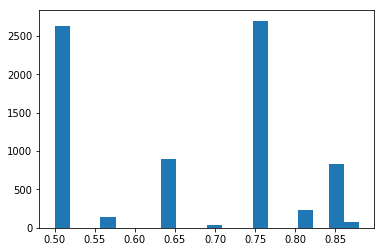

In [24]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [25]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.770640,0.6989,0.765297,0.536448
1,0.631160,0.6656,0.629349,0.418848
2,0.568375,0.6691,0.569982,0.385421


## Debugging  - Intermediate results on the dev set

Load L_gold_dev for the dev set.

In [26]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



Scores for the dev set.

In [27]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.704
Neg. class accuracy: 0.491
Precision            0.55
Recall               0.704
F1                   0.618
----------------------------------------
TP: 381 | FP: 312 | TN: 301 | FN: 160



In [28]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [29]:
sv

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzgzXSwgWzE4Nl0sIFs1Nl1dLCBbWzIxNl0sIFsyMjRdLCBbMjQ5XV0sIFtbMTEzXSwgWzldLCBbMTgyLCAyMDgsIDI2MV1dLCBbWzI2XSwgWzLigKY=


In [30]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_antonyms,0,0.491334,0.111785,0.0,336,55,0,0,0.859335,0.754850
LF_contrast_words_in_s,1,0.176776,0.089255,0.0,103,16,0,0,0.865546,0.637235
LF_intensifier_before,2,0.056326,0.038995,0.0,24,7,0,0,0.774194,0.573077


## Train the Discriminative Model

In [31]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 7542 marginals
CPU times: user 4.2 s, sys: 20.1 ms, total: 4.22 s
Wall time: 4.22 s


In [32]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [33]:
train_cands = session.query(Sentiment).filter(Sentiment.split == 0).order_by(Sentiment.id).all()
dev_cands   = session.query(Sentiment).filter(Sentiment.split == 1).order_by(Sentiment.id).all()
test_cands  = session.query(Sentiment).filter(Sentiment.split == 2).order_by(Sentiment.id).all()

In [34]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [35]:
from snorkel.learning.pytorch.rnn import LSTM

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm = LSTM(n_threads=1)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)



[LSTM] Training model
[LSTM] n_train=4913  #epochs=10  batch size=128
[LSTM] Epoch 1 (6.21s)	Average loss=0.649912	Dev F1=63.83
[LSTM] Epoch 2 (13.17s)	Average loss=0.640262	Dev F1=63.83
[LSTM] Epoch 3 (19.82s)	Average loss=0.639672	Dev F1=63.83
[LSTM] Epoch 4 (27.71s)	Average loss=0.638610	Dev F1=63.83
[LSTM] Epoch 5 (35.99s)	Average loss=0.636920	Dev F1=63.83
[LSTM] Epoch 6 (44.09s)	Average loss=0.635143	Dev F1=63.83
[LSTM] Epoch 7 (52.75s)	Average loss=0.631516	Dev F1=63.83
[LSTM] Epoch 8 (62.30s)	Average loss=0.628489	Dev F1=63.95
[LSTM] Epoch 9 (71.33s)	Average loss=0.624042	Dev F1=63.44
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 10 (79.56s)	Average loss=0.619458	Dev F1=63.81
[LSTM] Model saved as <LSTM>
[LSTM] Training done (80.49s)
[LSTM] Loaded model <LSTM>


## Results
In my opinion the results look promising, even though they are not entirely reliable. This is because of how the gold set was created. The proper way would have been to go through all of the words marked as candidates in the gold set and then manually anotate then as either polar or not polar. However, what I have done instead, is create a script that uses a list of positive & negative words (according to Senti Wordnet) to mark adjectives in the texts.

In [36]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.511, Recall: 0.985, F1 Score: 0.673


In [37]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.985
Neg. class accuracy: 0.0182
Precision            0.511
Recall               0.985
F1                   0.673
----------------------------------------
TP: 452 | FP: 432 | TN: 8 | FN: 7



In [38]:
lstm.save_marginals(session, test_cands)

Saved 899 marginals
